<a href="https://colab.research.google.com/github/uginm102/MCSC-MUK/blob/main/MCS7227%20Data%20Analytics%20and%20Visualization/MCS_7227_Data_Analytics_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Heart Disease Prediction with Global Factors
We shall be using medical data (e.g., age, BMI) and joining it with nationality and GDP to predict heart disease risk across different countries.

##Import relevant assemblies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, classification_report,  roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
import graphviz


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Load Data

In [ ]:
# File path to the cleaned dataset
input_file = "/content/drive/MyDrive/Personal/Masters/Msc Comp Sc - MUK/Year 1/Sem 2/MCS7227 Data Analytics and Visualization/heart_attack_prediction_dataset.csv"

# Load the cleaned dataset
df = pd.read_csv(input_file)

df.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


##Data Cleaning

Drop Patient ID for Redundancy

In [ ]:
df = df.drop(columns = "Patient ID")
df

,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,67,Male,208,158/88,72,0,0,1,0,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,21,Male,389,165/93,98,1,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,21,Female,324,174/99,72,1,0,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,84,Male,383,163/100,73,1,1,1,0,1,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,66,Male,318,91/88,93,1,1,1,1,0,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,Male,121,94/76,61,1,1,1,0,1,...,10.806373,235420,19.655895,67,7,7,Thailand,Asia,Northern Hemisphere,0
8759,28,Female,120,157/102,73,1,0,0,1,0,...,3.833038,217881,23.993866,617,4,9,Canada,North America,Northern Hemisphere,0
8760,47,Male,250,161/75,105,0,1,1,1,1,...,2.375214,36998,35.406146,527,4,4,Brazil,South America,Southern Hemisphere,1
8761,36,Male,178,119/67,60,1,0,1,0,0,...,0.029104,209943,27.294020,114,2,8,Brazil,South America,Southern Hemisphere,0


Split BloodPresure to Systolic and Diastolic

In [ ]:
if 'Systolic' not in df.columns:
  # Splitting the column
  split_cols = df['Blood Pressure'].str.split('/', expand=True)
  split_cols.columns = ['Systolic', 'Diastolic']

  # Convert to numeric (optional, for calculations)
  split_cols['Systolic'] = pd.to_numeric(split_cols['Systolic'])
  split_cols['Diastolic'] = pd.to_numeric(split_cols['Diastolic'])

  # Inserting new columns next to BloodPressure
  bp_index = df.columns.get_loc('Blood Pressure')  # Get index of BloodPressure column
  for i, col in enumerate(split_cols.columns):
      df.insert(bp_index + 1 + i, col, split_cols[col])

#Drop the Blood Pressure Column
if 'Blood Pressure' in df.columns:
  df = df.drop(columns = "Blood Pressure")
df

,Age,Sex,Cholesterol,Systolic,Diastolic,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,67,Male,208,158,88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,21,Male,389,165,93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,21,Female,324,174,99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,84,Male,383,163,100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,66,Male,318,91,88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,Male,121,94,76,61,1,1,1,0,...,10.806373,235420,19.655895,67,7,7,Thailand,Asia,Northern Hemisphere,0
8759,28,Female,120,157,102,73,1,0,0,1,...,3.833038,217881,23.993866,617,4,9,Canada,North America,Northern Hemisphere,0
8760,47,Male,250,161,75,105,0,1,1,1,...,2.375214,36998,35.406146,527,4,4,Brazil,South America,Southern Hemisphere,1
8761,36,Male,178,119,67,60,1,0,1,0,...,0.029104,209943,27.294020,114,2,8,Brazil,South America,Southern Hemisphere,0


###Checking for Missing Values

In [ ]:
df.isnull().sum()

,0
Age,0
Sex,0
Cholesterol,0
Systolic,0
Diastolic,0
Heart Rate,0
Diabetes,0
Family History,0
Smoking,0
Obesity,0


In [ ]:
# Extract rows and columns where data is missing
missing_values = df[df.isnull().any(axis=1)][df.columns[df.isnull().any(axis=0)]]
print("\nRows and columns with missing values:")
print(missing_values)


Rows and columns with missing values:
Empty DataFrame
Columns: []
Index: []


## Exploratory analysis

In [ ]:
rows, columns = df.shape
print(f"Number of rows: {rows}, Number of columns: {columns}")
print(df.keys())
df.info()

Number of rows: 8763, Number of columns: 26
Index(['Age', 'Sex', 'Cholesterol', 'Systolic', 'Diastolic', 'Heart Rate',
       'Diabetes', 'Family History', 'Smoking', 'Obesity',
       'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country',
       'Continent', 'Hemisphere', 'Heart Attack Risk'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8763 non-null   int64  
 1   Sex                              8763 non-null   object 
 2   Cholesterol                      8763 non-null   int64  
 3   Systolic                         8763 non-nul

We have 8,763 rows to deal with each with 26 properties.

Dataset Glossary (Column-wise)
1. Patient ID - Unique identifier for each patient
2. Age - Age of the patient
3. Sex - Gender of the patient (Male/Female)
4. Cholesterol - Cholesterol levels of the patient
5. Blood Pressure - Blood pressure of the patient (systolic/diastolic)
6. Heart Rate - Heart rate of the patient
7. Diabetes - Whether the patient has diabetes (Yes/No)
8. Family History - Family history of heart-related problems (1: Yes, 0: No)
9. Smoking - Smoking status of the patient (1: Smoker, 0: Non-smoker)
10. Obesity - Obesity status of the patient (1: Obese, 0: Not obese)
11. Alcohol Consumption - Level of alcohol consumption by the patient (None/Light/Moderate/Heavy)
12. Exercise Hours Per Week - Number of exercise hours per week
13. Diet - Dietary habits of the patient (Healthy/Average/Unhealthy)
14. Previous Heart Problems - Previous heart problems of the patient (1: Yes, 0: No)
15. Medication Use - Medication usage by the patient (1: Yes, 0: No)
16. Stress Level - Stress level reported by the patient (1-10)
17. Sedentary Hours Per Day - Hours of sedentary activity per day
18. Income - Income level of the patient
19. BMI - Body Mass Index (BMI) of the patient
20. Triglycerides - Triglyceride levels of the patient
21. Physical Activity Days Per Week - Days of physical activity per week
22. Sleep Hours Per Day - Hours of sleep per day
23. Country - Country of the patient
24. Continent - Continent where the patient resides
25. Hemisphere - Hemisphere where the patient resides
26. Heart Attack Risk - Presence of heart attack risk (1: Yes, 0: No)

###Age Distribution

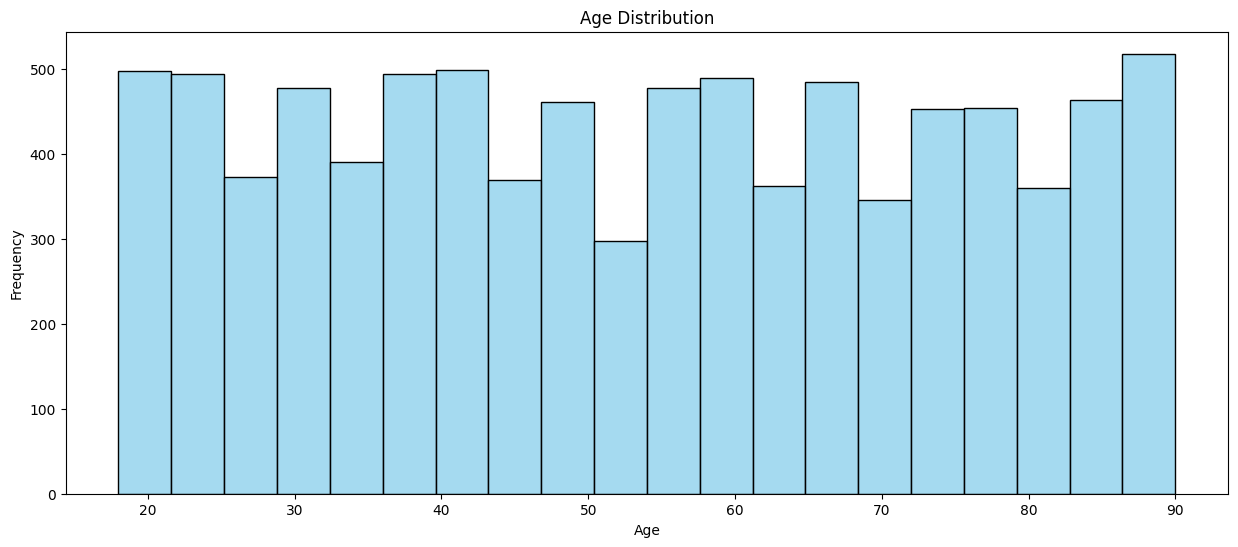

In [ ]:
plt.figure(figsize=(15, 6))
sns.histplot(df['Age'], kde=False, bins=20, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

###Income Distribution

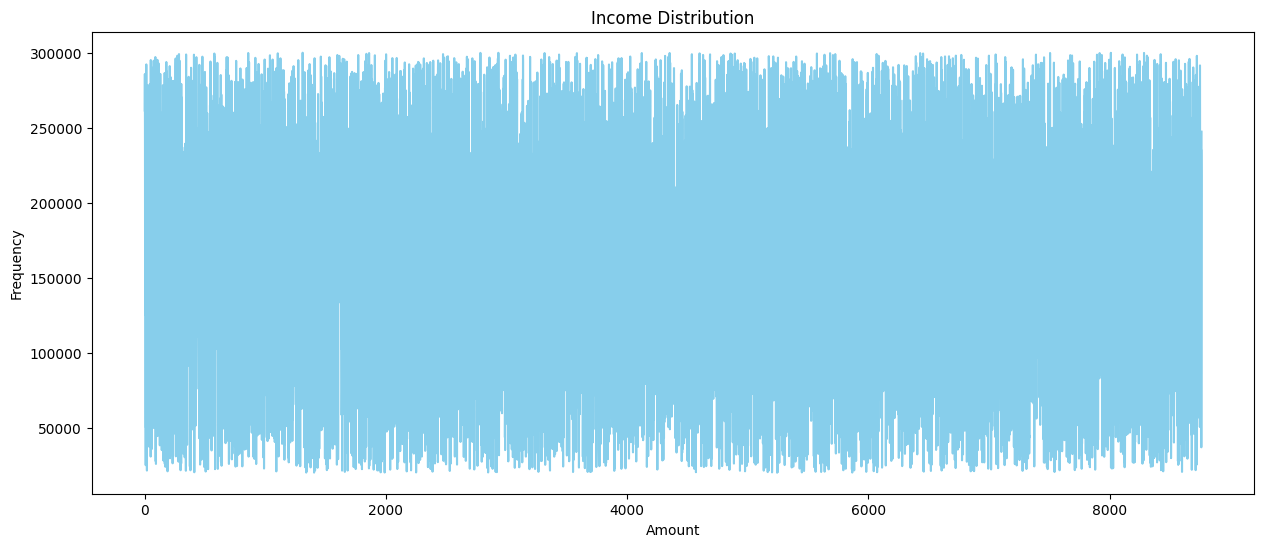

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(df['Income'],  color='skyblue')
plt.title('Income Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

In [ ]:
risk_by_income = df.groupby(['Income', 'Heart Attack Risk']).size().unstack(fill_value=0)
income_groups = risk_by_income.index
print(risk_by_income)
print(income_groups)

Heart Attack Risk  0  1
Income                 
20062              1  0
20140              1  0
20162              1  0
20165              1  0
20208              1  0
...               .. ..
299810             1  0
299850             0  1
299891             1  0
299909             0  1
299954             0  1

[8615 rows x 2 columns]
Index([ 20062,  20140,  20162,  20165,  20208,  20249,  20255,  20264,  20285,
        20328,
       ...
       299738, 299742, 299769, 299771, 299776, 299810, 299850, 299891, 299909,
       299954],
      dtype='int64', name='Income', length=8615)


###Heart Attack Risk by Gender

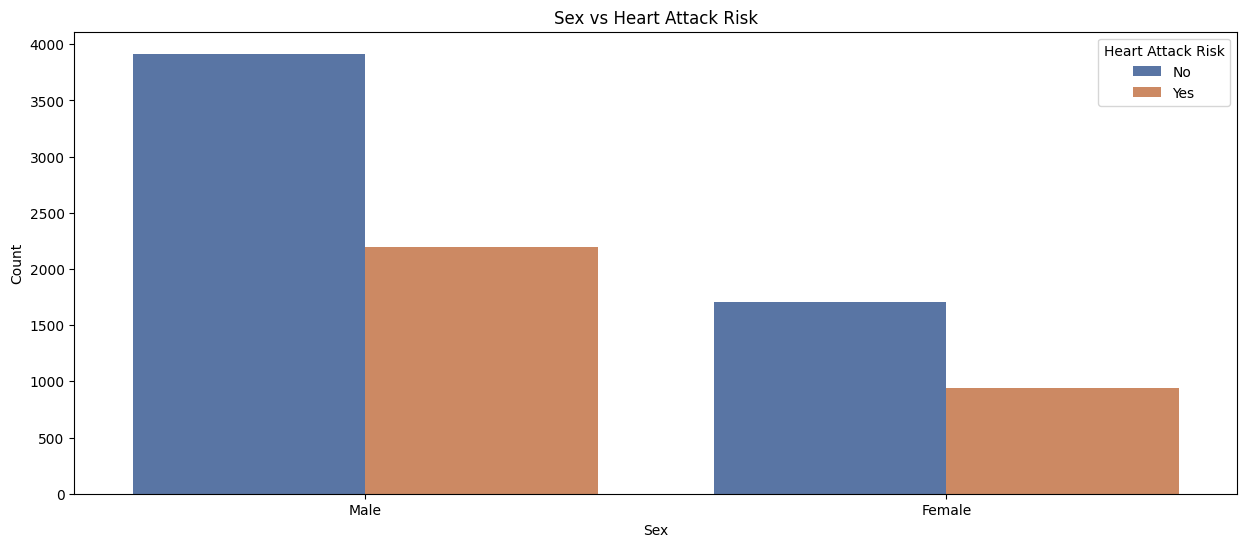

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='Sex', hue='Heart Attack Risk', palette='deep')
plt.title('Sex vs Heart Attack Risk')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Heart Attack Risk', labels=['No', 'Yes'])
plt.show()

In [ ]:
# Pie Chart Data
risk_by_sex = df.groupby(['Sex', 'Heart Attack Risk']).size().unstack(fill_value=0)
male_percentages = risk_by_sex.loc['Male'] / risk_by_sex.loc['Male'].sum() * 100
female_percentages = risk_by_sex.loc['Female'] / risk_by_sex.loc['Female'].sum() * 100

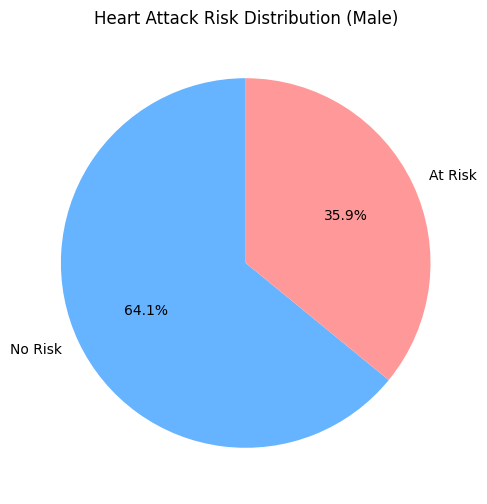

In [ ]:
# Pie Chart for Male
plt.figure(figsize=(6, 6))
plt.pie(male_percentages, labels=['No Risk', 'At Risk'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Heart Attack Risk Distribution (Male)')
plt.show()

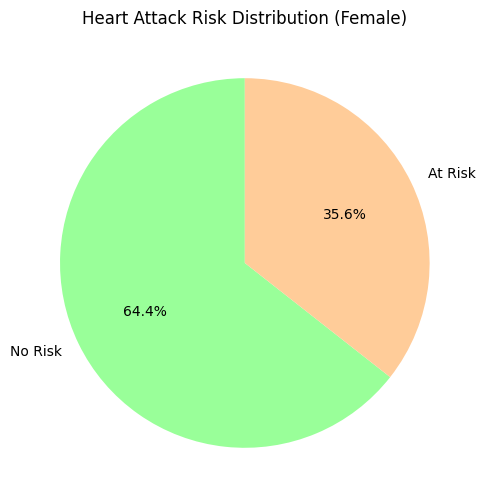

In [ ]:
# Pie Chart for Female
plt.figure(figsize=(6, 6))
plt.pie(female_percentages, labels=['No Risk', 'At Risk'], autopct='%1.1f%%', startangle=90, colors=['#99ff99', '#ffcc99'])
plt.title('Heart Attack Risk Distribution (Female)')
plt.show()

###Heart Attack Risk By Age

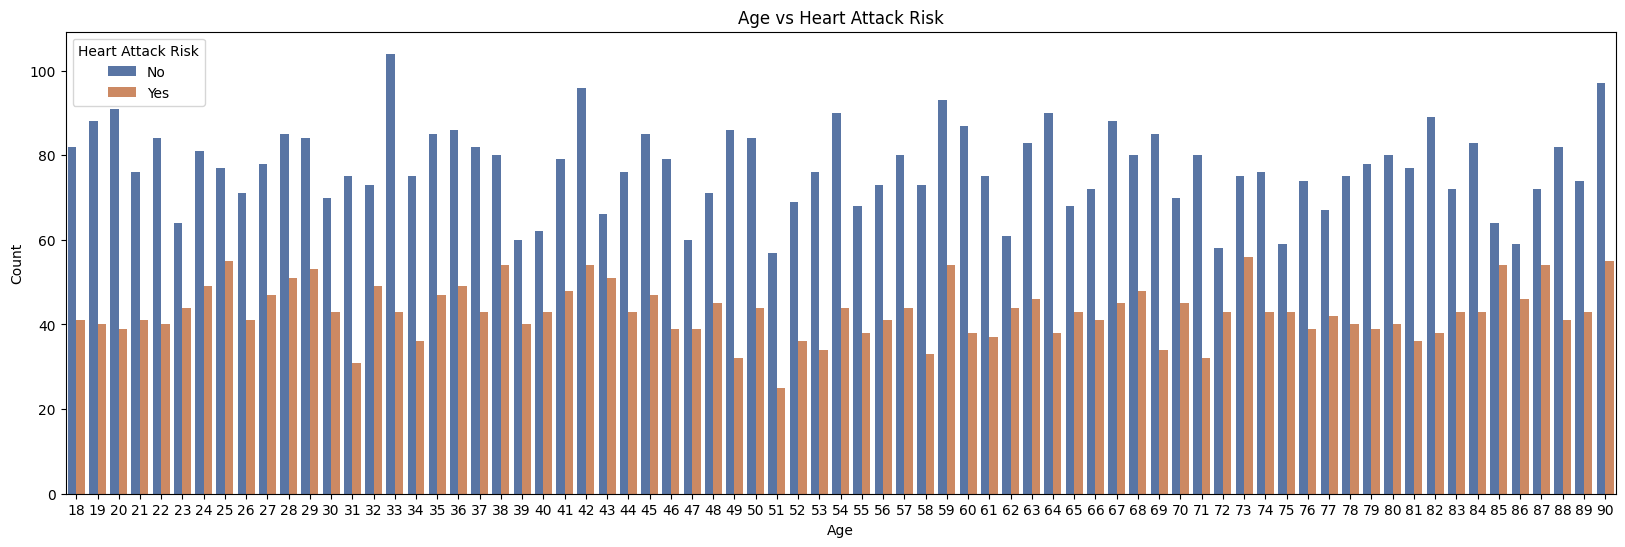

In [ ]:
# Bar Plot for Age vs Heart Attack Risk
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x='Age', hue='Heart Attack Risk', palette='deep')
plt.title('Age vs Heart Attack Risk')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Heart Attack Risk', labels=['No', 'Yes'])
plt.show()

###Highest/Lowest Risk of Heart Attack on Specific Age

In [ ]:
risk_by_age = df.groupby(['Age', 'Heart Attack Risk']).size().unstack(fill_value=0)
age_groups = risk_by_age.index
# print(risk_by_age)

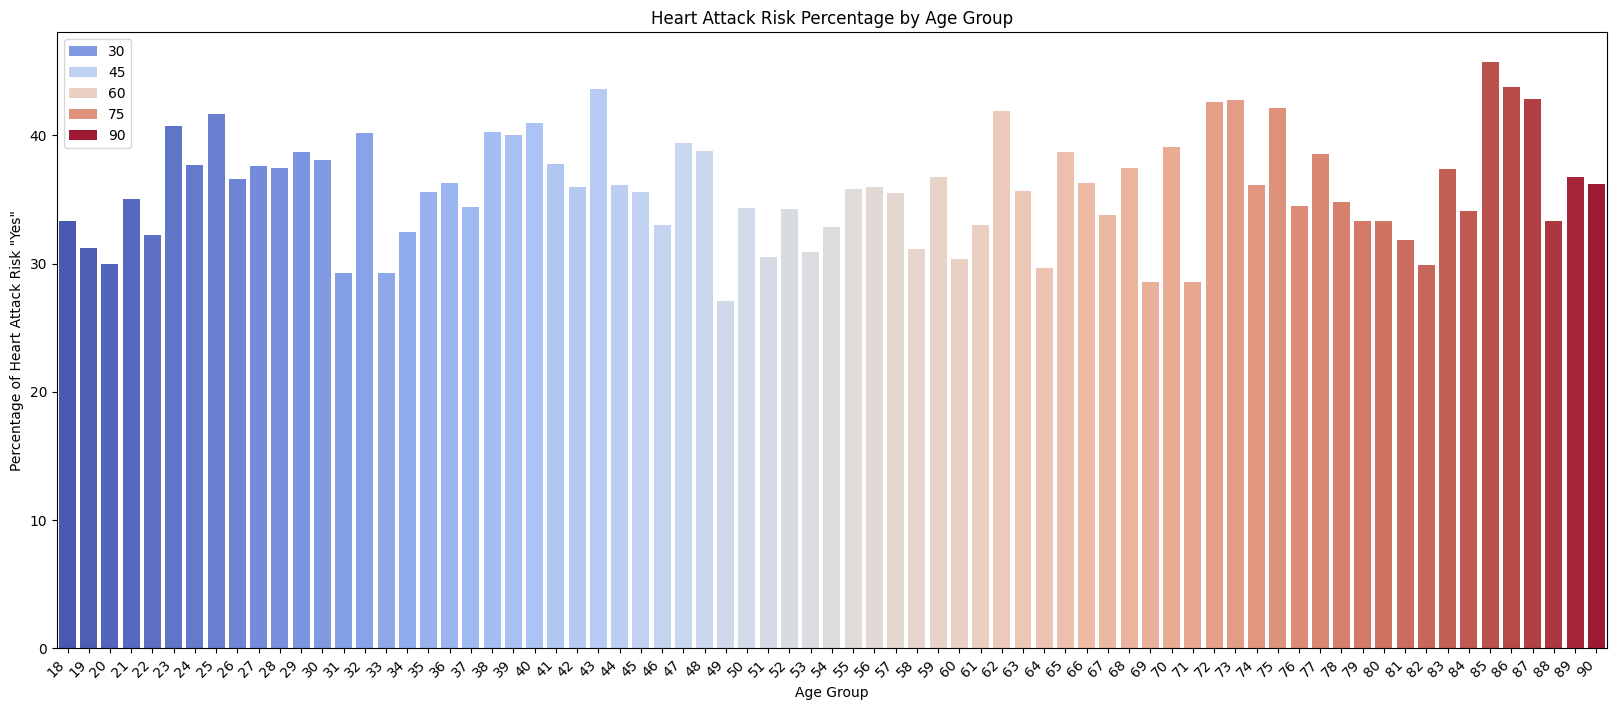

Age group with the lowest heart attack risk ('Yes'): 49 (27.12%)
Age group with the highest heart attack risk ('Yes'): 85 (45.76%)


In [ ]:
# Calculate percentages of 'Yes' for each age group
age_risk_percentages = risk_by_age.div(risk_by_age.sum(axis=1), axis=0) * 100

# Find the age groups with the lowest and highest percentage of "Yes"
lowest_risk_age = age_risk_percentages[1].idxmin()
highest_risk_age = age_risk_percentages[1].idxmax()

# Get the percentage for the lowest and highest risk age groups
lowest_risk_percentage = age_risk_percentages.loc[lowest_risk_age, 1]
highest_risk_percentage = age_risk_percentages.loc[highest_risk_age, 1]

# Plotting
plt.figure(figsize=(20, 8))
sns.barplot(x=age_risk_percentages.index, y=age_risk_percentages[1], palette='coolwarm', hue=age_risk_percentages.index)

# Highlight the lowest and highest
# plt.scatter(lowest_risk_age, lowest_risk_percentage, color='red', s=100, label=f"Lowest: {lowest_risk_age} ({lowest_risk_percentage:.2f}%)")
# plt.scatter(highest_risk_age, highest_risk_percentage, color='green', s=100, label=f"Highest: {highest_risk_age} ({highest_risk_percentage:.2f}%)")

# Labels and title
plt.title('Heart Attack Risk Percentage by Age Group')
plt.xlabel('Age Group')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Heart Attack Risk "Yes"')
plt.legend()
plt.show()

# Output the results
print(f"Age group with the lowest heart attack risk ('Yes'): {lowest_risk_age} ({lowest_risk_percentage:.2f}%)")
print(f"Age group with the highest heart attack risk ('Yes'): {highest_risk_age} ({highest_risk_percentage:.2f}%)")

###Heart Attack Risk Case by Country

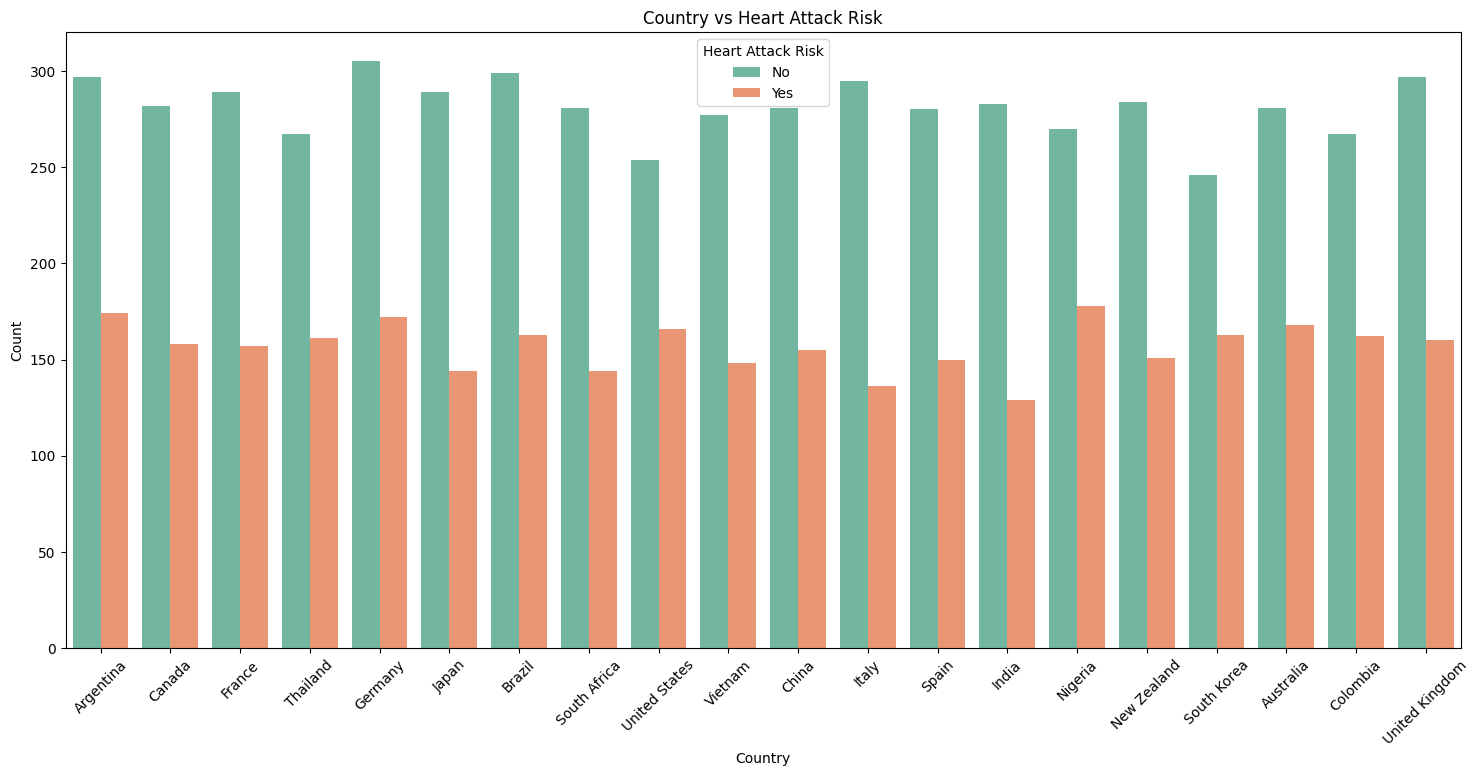

In [ ]:
# Plotting Country vs Heart Attack Risk
plt.figure(figsize=(18, 8))
sns.countplot(data=df, x='Country', hue='Heart Attack Risk', palette='Set2')

# Labels and title
plt.title('Country vs Heart Attack Risk')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate country labels to fit them
plt.legend(title='Heart Attack Risk', labels=['No', 'Yes'])
plt.show()

It seems like the risk is spread almost evenly amongs all countries despite their income levels.

However, we are only looking at recorded data and their is a chance that mainly people in certain income ranges do have heart check ups.

###Heart Risk Attack by Continent

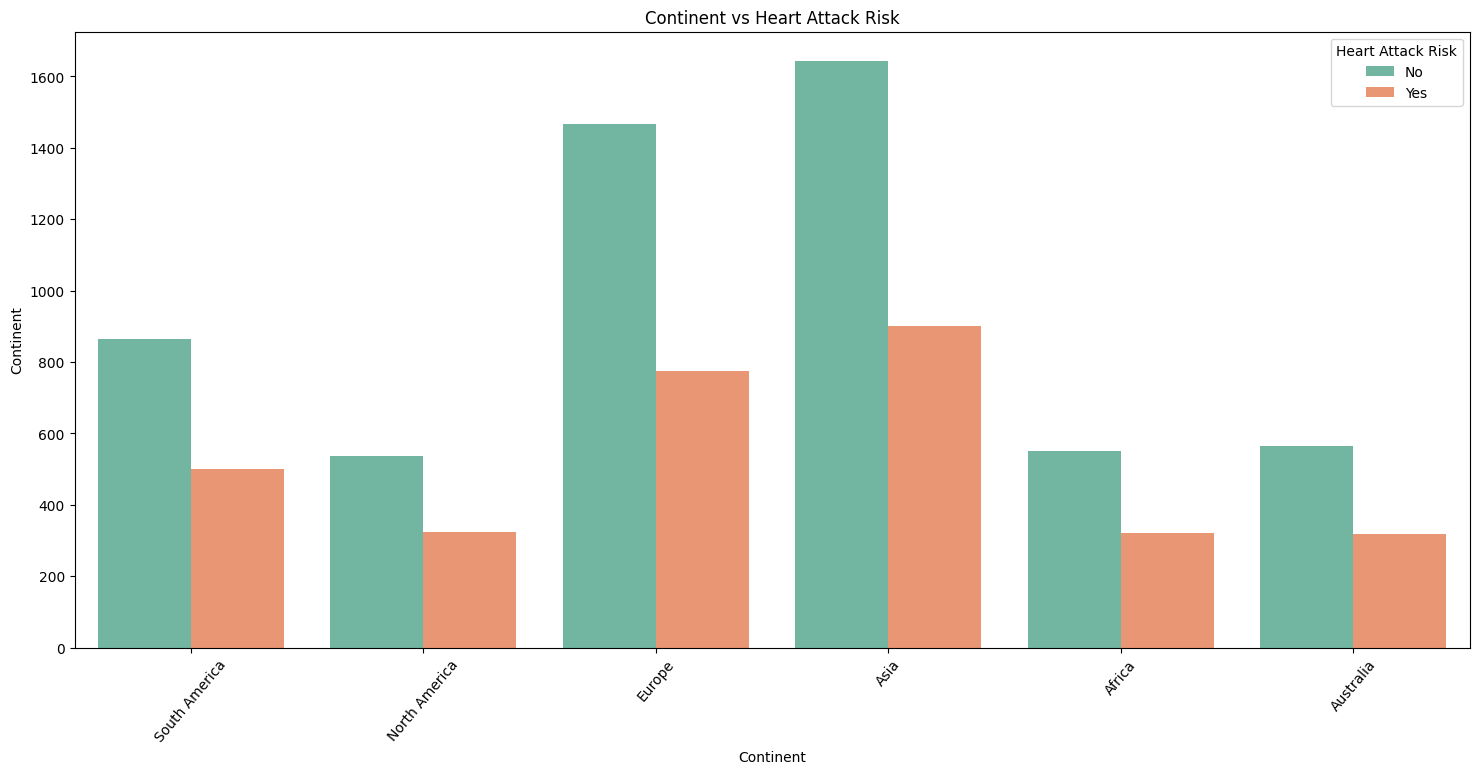

In [ ]:
# Plotting Continent vs Heart Attack Risk
plt.figure(figsize=(18, 8))
sns.countplot(data=df, x='Continent', hue='Heart Attack Risk', palette='Set2')

# Labels and title
plt.title('Continent vs Heart Attack Risk')
plt.xlabel('Continent')
plt.ylabel('Continent')
plt.xticks(rotation=50)  # Rotate country labels to fit them
plt.legend(title='Heart Attack Risk', labels=['No', 'Yes'])
plt.show()

We can see that North American had a comparable risk with Africa, and Asia had the highest risk. Which again doesn't stress enough the risk as a social economic factor straight forwards.

In [ ]:
# # Plotting Income vs Heart Attack Risk
# plt.figure(figsize=(18, 8))
# sns.countplot(data=df, x='Income', hue='Heart Attack Risk', palette='Set2')

# # Labels and title
# plt.title('Income vs Heart Attack Risk')
# plt.xlabel('Income')
# plt.ylabel('Count')
# plt.xticks(rotation=90)  # Rotate Income labels to fit them
# plt.legend(title='Heart Attack Risk', labels=['No', 'Yes'])
# plt.show()

##Data Preprocessing
Encode Categorical Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8763 non-null   int64  
 1   Sex                              8763 non-null   object 
 2   Cholesterol                      8763 non-null   int64  
 3   Systolic                         8763 non-null   int64  
 4   Diastolic                        8763 non-null   int64  
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

###Label Encoding Boolean (Yes/No) Data

In [ ]:
# Loop through all columns and apply encoding for 'Yes'/'No' values
# use a copy of the data frame
clean_df = df.copy()
for column in clean_df.columns:
    if df[column].dtype == 'object' and df[column].isin(['Yes', 'No']).all():
        df[column] = df[column].map({'No': 0, 'Yes': 1})

# Verify the encoding
clean_df

,Age,Sex,Cholesterol,Systolic,Diastolic,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,67,Male,208,158,88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,21,Male,389,165,93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,21,Female,324,174,99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,84,Male,383,163,100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,66,Male,318,91,88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,Male,121,94,76,61,1,1,1,0,...,10.806373,235420,19.655895,67,7,7,Thailand,Asia,Northern Hemisphere,0
8759,28,Female,120,157,102,73,1,0,0,1,...,3.833038,217881,23.993866,617,4,9,Canada,North America,Northern Hemisphere,0
8760,47,Male,250,161,75,105,0,1,1,1,...,2.375214,36998,35.406146,527,4,4,Brazil,South America,Southern Hemisphere,1
8761,36,Male,178,119,67,60,1,0,1,0,...,0.029104,209943,27.294020,114,2,8,Brazil,South America,Southern Hemisphere,0


Label Encode "Sex" and "Diet" Column

In [ ]:
# Encoding 'Sex' column: Female = 0, Male = 1
clean_df['Sex'] = clean_df['Sex'].map({'Female': 0, 'Male': 1})

# Encoding 'Diet' column: Unhealthy = 0, Average = 1, Healthy = 2
clean_df['Diet'] = clean_df['Diet'].map({'Unhealthy': 0, 'Average': 1, 'Healthy': 2})

# Verify the encoding
print(clean_df[['Sex', 'Diet']].head())

   Sex  Diet
0    1     1
1    1     0
2    0     2
3    1     1
4    1     0


One-Hot Encoding "Continent" and "Hemisphere"

In [ ]:
# One-Hot Encoding for 'Continent' and 'Hemisphere'
clean_df = pd.get_dummies(clean_df, columns=['Continent', 'Hemisphere'], drop_first=True)

# Verify the changes
print(clean_df.head())

   Age  Sex  Cholesterol  Systolic  Diastolic  Heart Rate  Diabetes  \
0   67    1          208       158         88          72         0   
1   21    1          389       165         93          98         1   
2   21    0          324       174         99          72         1   
3   84    1          383       163        100          73         1   
4   66    1          318        91         88          93         1   

   Family History  Smoking  Obesity  ...  Physical Activity Days Per Week  \
0               0        1        0  ...                                0   
1               1        1        1  ...                                1   
2               0        0        0  ...                                4   
3               1        1        0  ...                                3   
4               1        1        1  ...                                1   

   Sleep Hours Per Day    Country  Heart Attack Risk  Continent_Asia  \
0                    6  Argentina     

In [ ]:
# Reorder columns: move 'Heart Attack Risk' to the most right
cols = [col for col in clean_df.columns if col != 'Heart Attack Risk']  # All columns except 'Heart Attack Risk'
clean_df = clean_df[cols + ['Heart Attack Risk']]  # Append 'Heart Attack Risk' to the rightmost position

# Verify the changes
clean_df

,Age,Sex,Cholesterol,Systolic,Diastolic,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent_Asia,Continent_Australia,Continent_Europe,Continent_North America,Continent_South America,Hemisphere_Southern Hemisphere,Heart Attack Risk
0,67,1,208,158,88,72,0,0,1,0,...,0,6,Argentina,False,False,False,False,True,True,0
1,21,1,389,165,93,98,1,1,1,1,...,1,7,Canada,False,False,False,True,False,False,0
2,21,0,324,174,99,72,1,0,0,0,...,4,4,France,False,False,True,False,False,False,0
3,84,1,383,163,100,73,1,1,1,0,...,3,4,Canada,False,False,False,True,False,False,0
4,66,1,318,91,88,93,1,1,1,1,...,1,5,Thailand,True,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,1,121,94,76,61,1,1,1,0,...,7,7,Thailand,True,False,False,False,False,False,0
8759,28,0,120,157,102,73,1,0,0,1,...,4,9,Canada,False,False,False,True,False,False,0
8760,47,1,250,161,75,105,0,1,1,1,...,4,4,Brazil,False,False,False,False,True,True,1
8761,36,1,178,119,67,60,1,0,1,0,...,2,8,Brazil,False,False,False,False,True,True,0


Drop "Country" Column

In [ ]:
clean_df = clean_df.drop(columns="Country")
clean_df

,Age,Sex,Cholesterol,Systolic,Diastolic,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Continent_Asia,Continent_Australia,Continent_Europe,Continent_North America,Continent_South America,Hemisphere_Southern Hemisphere,Heart Attack Risk
0,67,1,208,158,88,72,0,0,1,0,...,286,0,6,False,False,False,False,True,True,0
1,21,1,389,165,93,98,1,1,1,1,...,235,1,7,False,False,False,True,False,False,0
2,21,0,324,174,99,72,1,0,0,0,...,587,4,4,False,False,True,False,False,False,0
3,84,1,383,163,100,73,1,1,1,0,...,378,3,4,False,False,False,True,False,False,0
4,66,1,318,91,88,93,1,1,1,1,...,231,1,5,True,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,1,121,94,76,61,1,1,1,0,...,67,7,7,True,False,False,False,False,False,0
8759,28,0,120,157,102,73,1,0,0,1,...,617,4,9,False,False,False,True,False,False,0
8760,47,1,250,161,75,105,0,1,1,1,...,527,4,4,False,False,False,False,True,True,1
8761,36,1,178,119,67,60,1,0,1,0,...,114,2,8,False,False,False,False,True,True,0


Verify Data Types

In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8763 non-null   int64  
 1   Sex                              8763 non-null   int64  
 2   Cholesterol                      8763 non-null   int64  
 3   Systolic                         8763 non-null   int64  
 4   Diastolic                        8763 non-null   int64  
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

##Feature Distribution

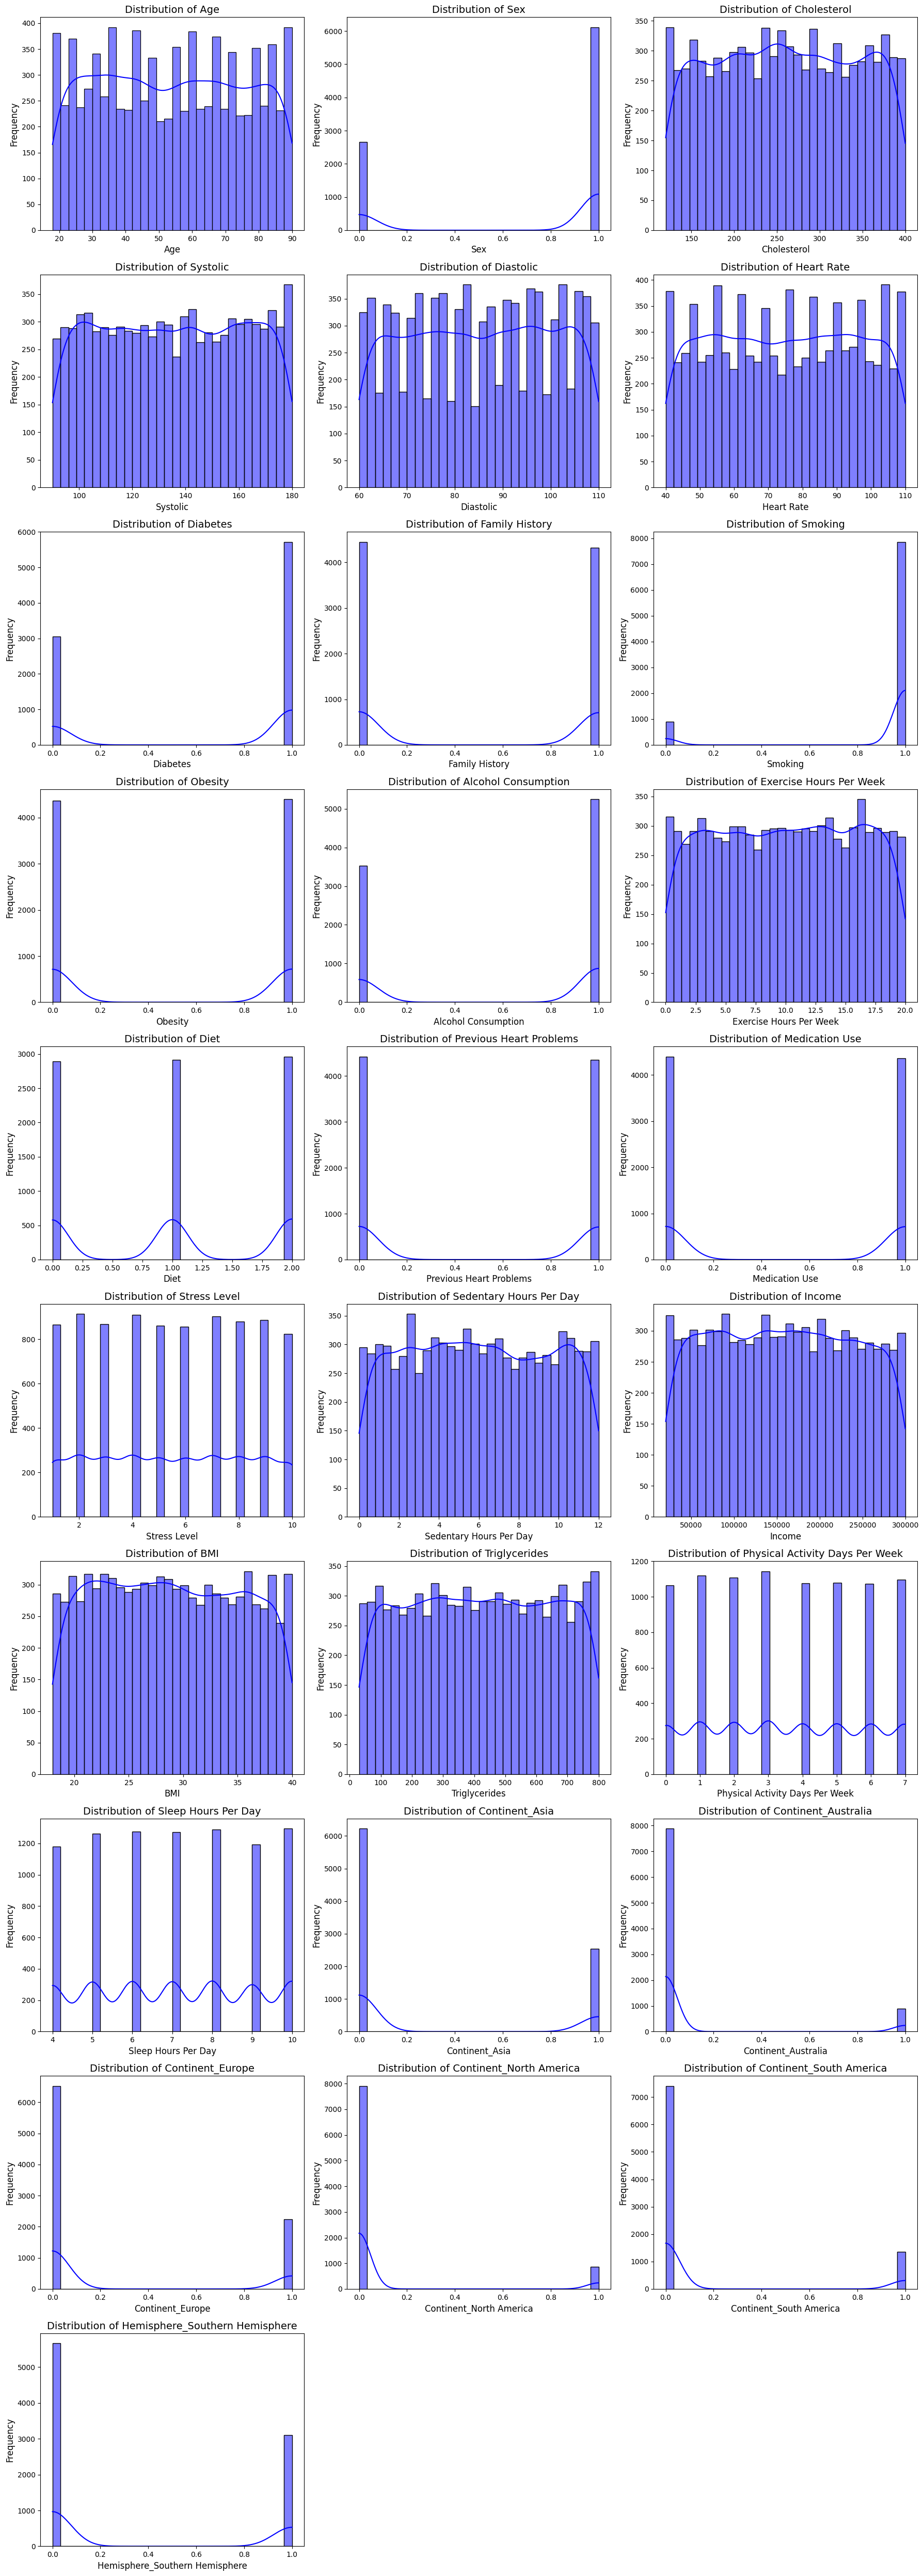

In [ ]:
df_features = clean_df.iloc[:, :-1]

# Visualize the distribution of all features except the target
def plot_distributions(clean_df, cols_per_row=3):
    num_cols = len(clean_df.columns)
    num_rows = (num_cols // cols_per_row) + int(num_cols % cols_per_row > 0)

    plt.figure(figsize=(cols_per_row * 6, num_rows * 5))
    for i, column in enumerate(clean_df.columns, 1):
        plt.subplot(num_rows, cols_per_row, i)
        sns.histplot(clean_df[column], kde=True, bins=30, color='blue', edgecolor='black')
        plt.title(f"Distribution of {column}", fontsize=14)  # Increased title font size
        plt.xlabel(column, fontsize=12)  # Increased x-label font size
        plt.ylabel("Frequency", fontsize=12)  # Increased y-label font size
        plt.tight_layout()
    plt.show()

# Call the function to plot distributions
plot_distributions(df_features, cols_per_row=3)

###Checking for Outliers

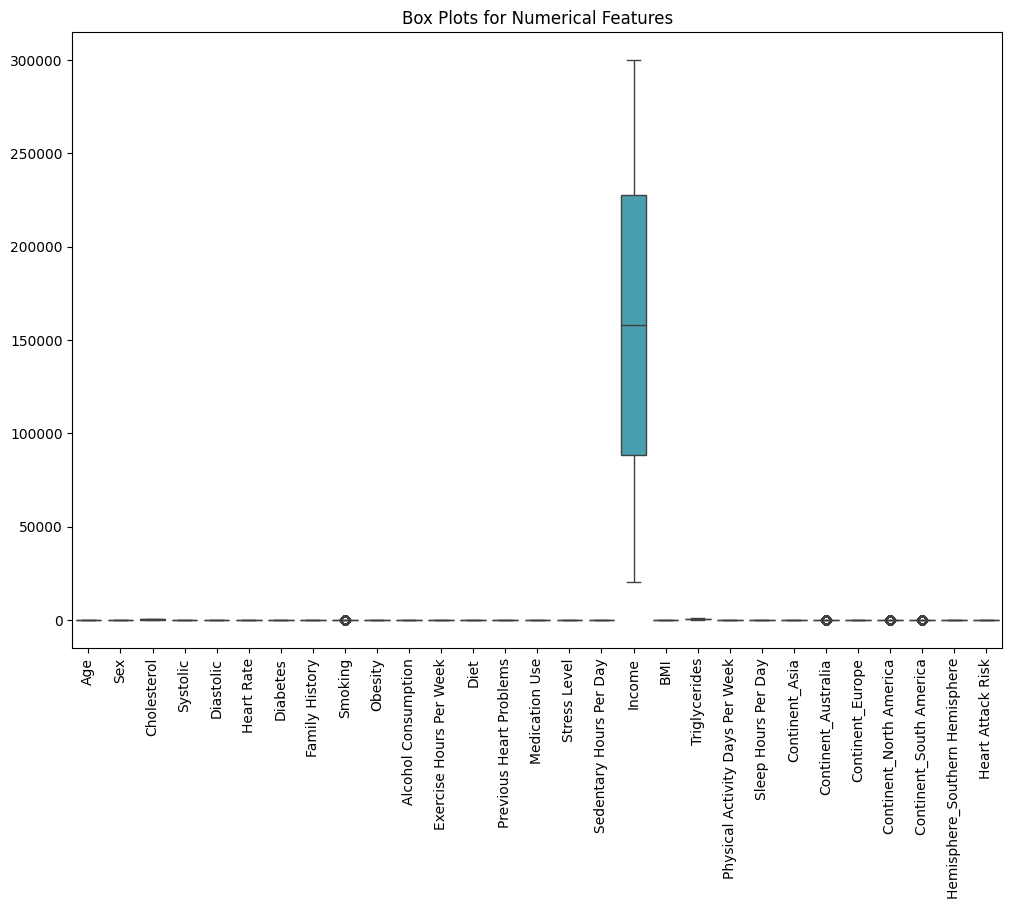

In [ ]:
# Plot boxplots for numerical columns
plt.figure(figsize=(12, 8))
sns.boxplot(data=clean_df)
plt.xticks(rotation=90)
plt.title('Box Plots for Numerical Features')
plt.show()

###Correlation Heatmap

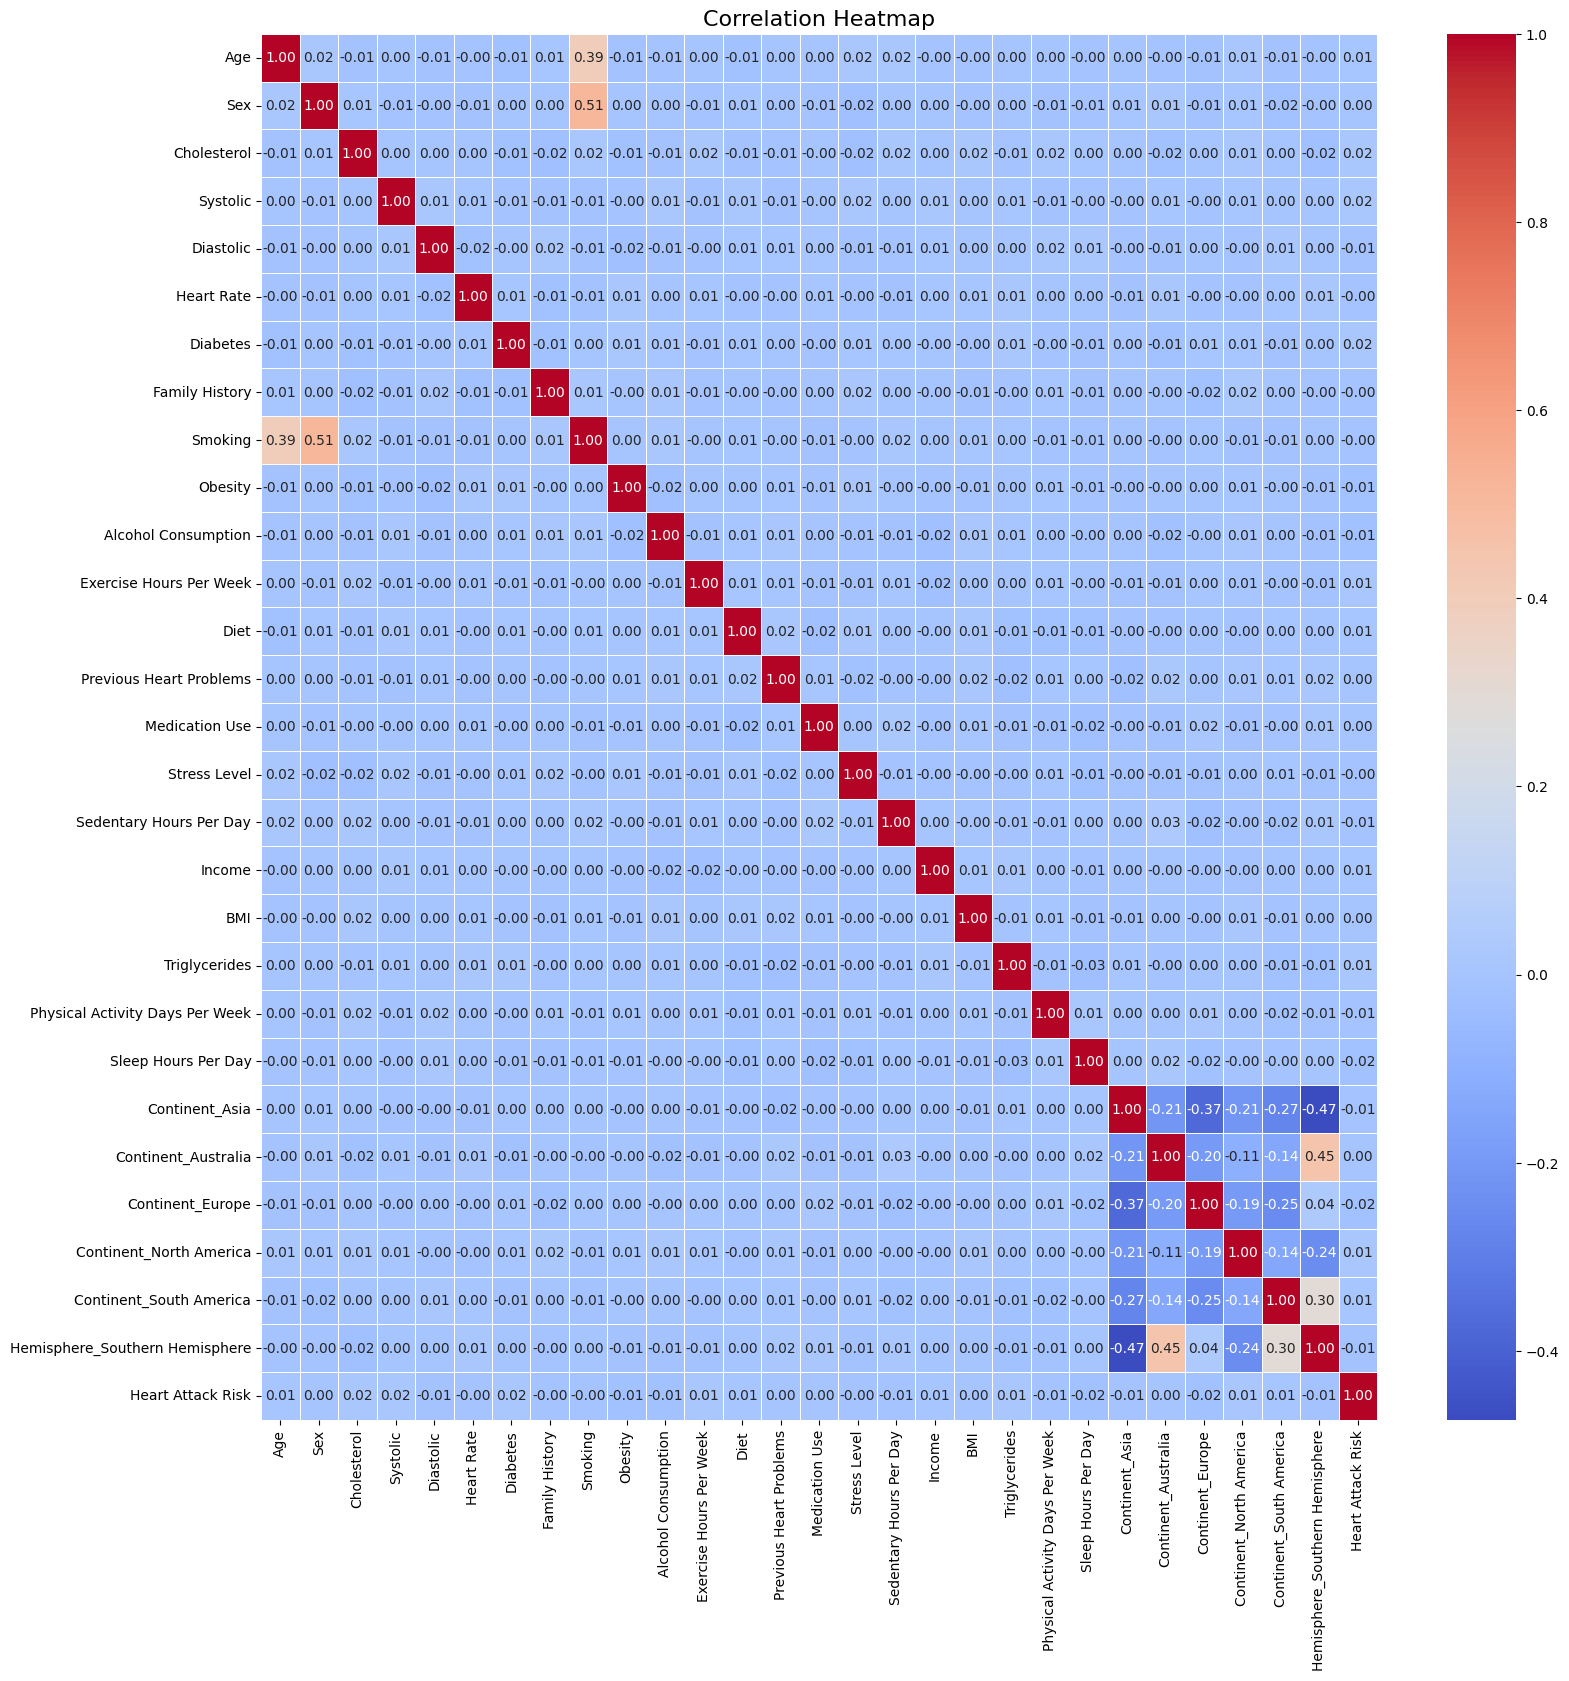

In [ ]:
# Compute the correlation matrix
correlation_matrix = clean_df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(18, 18))  # Adjust figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Customize the plot
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

###Density Plot

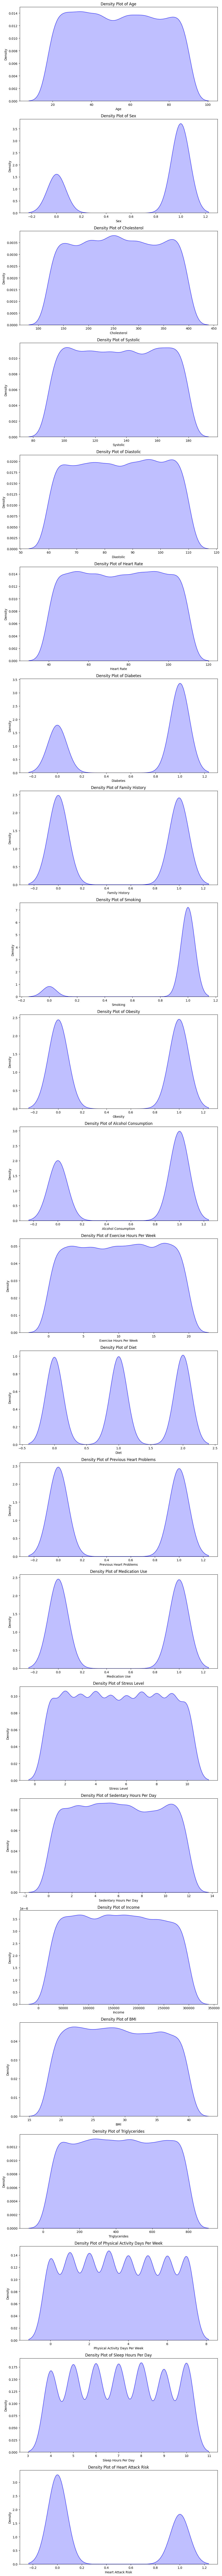

In [ ]:
# Select numeric columns
numeric_columns = clean_df.select_dtypes(include=['number']).columns

# Generate density plots for all numeric columns
plt.figure(figsize=(10, len(numeric_columns) * 5))  # Adjust figure size based on the number of columns
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)
    sns.kdeplot(clean_df[column], fill=True, color='blue')
    plt.title(f'Density Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

##Model Training using Random Forest

In [ ]:
# Prepare data
X = clean_df.drop(columns=[clean_df.columns[-1]])  # Drop the last column (target)
y = clean_df[clean_df.columns[-1]]  # Select the last column (target

# splitting X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6134, 28) (2629, 28) (6134,) (2629,)


### Hyperparameters

In [ ]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rf = RandomForestRegressor()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)



Best hyperparameters: {'max_depth': 1, 'n_estimators': 284}


In [ ]:
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=284, random_state=42, max_depth=1, criterion='gini')

# Train the classifier
rf_classifier.fit(X_train.values, y_train.values)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test.values)


# print the accuracy
print("Accuracy of Random Forest: ",
      accuracy_score(y_test, y_pred))
# print other performance metrics
print("Precision of Random Forest: ",
      precision_score(y_test, y_pred, average='weighted'))
print("Recall of Random Forest: ",
      recall_score(y_test, y_pred, average='weighted'))
print("F1-Score of Random Forest: ",
      f1_score(y_test, y_pred, average='weighted'))


# Evaluate the model
classification_rep = classification_report(y_test, y_pred)

# Print the results
print("\nClassification Report:\n", classification_rep)

Accuracy of Random Forest:  0.6466337010270065
Precision of Random Forest:  0.418135143303884
Recall of Random Forest:  0.6466337010270065
F1-Score of Random Forest:  0.5078666166532275

Classification Report:
               precision    recall  f1-score   support

           0       0.65      1.00      0.79      1700
           1       0.00      0.00      0.00       929

    accuracy                           0.65      2629
   macro avg       0.32      0.50      0.39      2629
weighted avg       0.42      0.65      0.51      2629



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Our model showed an accuracy of 64.6% which is not a very precise accuracy.

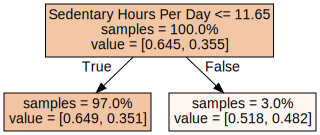

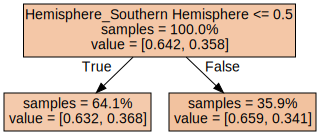

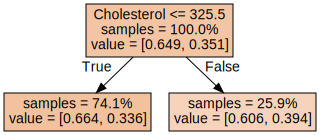

In [ ]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf_classifier.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

### ROC curve

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


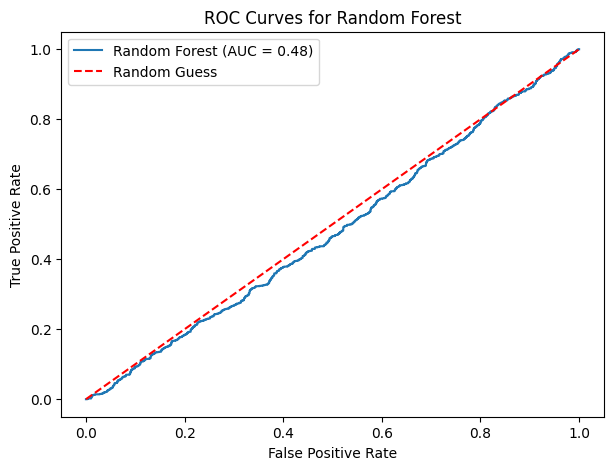

In [ ]:
# Plot ROC curve for model
plt.figure(figsize=(7, 5))
y_pred_rf = rf_classifier.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

roc_auc = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc:.2f})')


# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest')
plt.legend()
plt.show()

### Confusion matrix

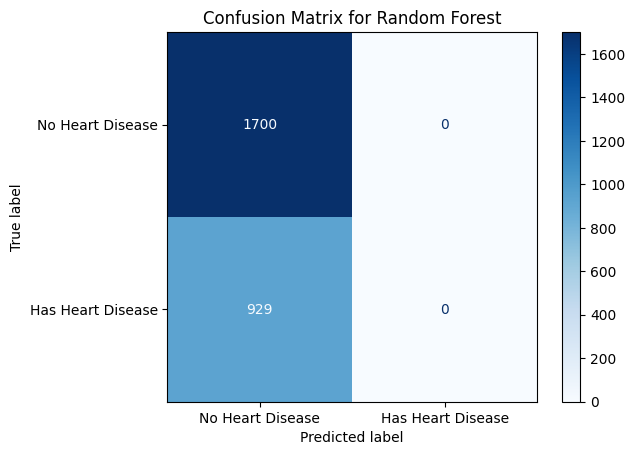

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Heart Disease','Has Heart Disease']);
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest')
plt.show()

###Feature Importance

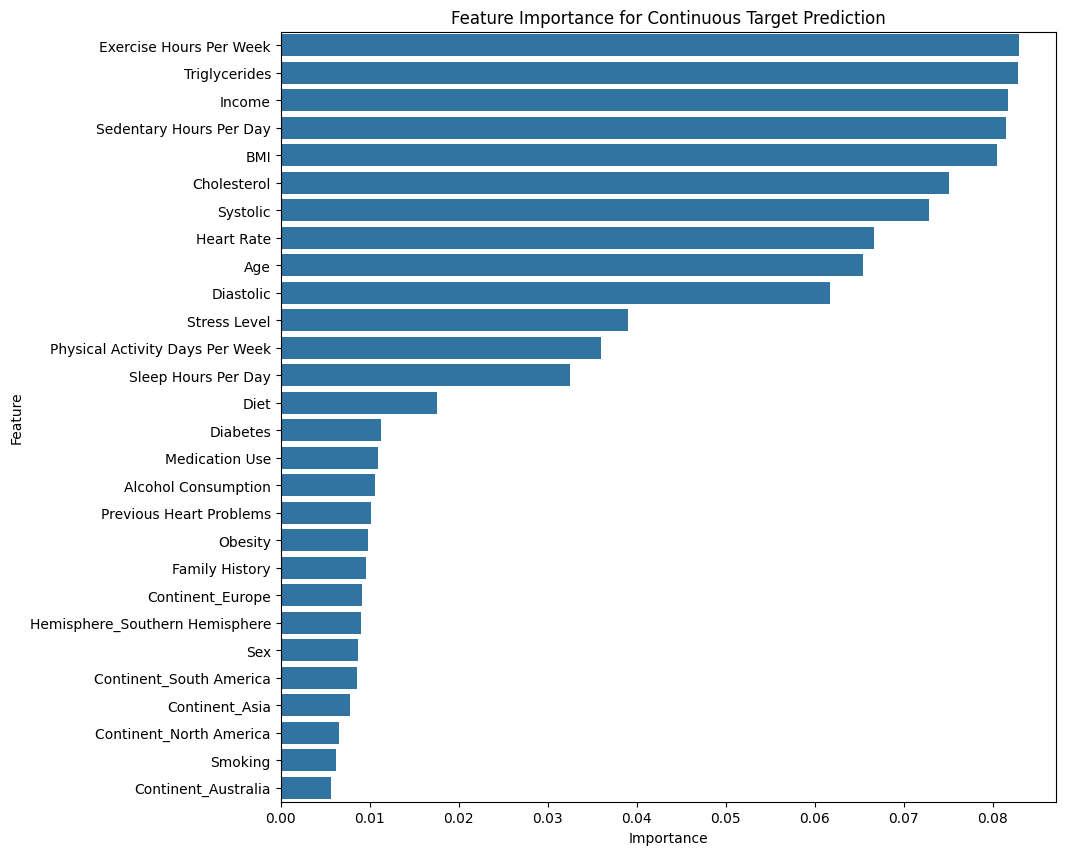

In [ ]:
# Get feature importances
importances = rf_classifier.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Feature Importance for Continuous Target Prediction')
plt.show()